In [4]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
plt.rcParams.update({'font.size':23}); plt.rcParams.update({'axes.linewidth':1.5}); plt.rc('axes', axisbelow=True);
plt.rc('lines',linewidth=3); plt.rcParams['axes.spines.right'] = False; plt.rcParams['axes.spines.top'] = False 
plt.rcParams['xtick.major.size'] = 8; plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.major.width'] = 2; plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.size'] = 8; plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.major.width'] = 2; plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.visible'] = True; plt.rcParams['ytick.minor.visible'] = True; 
plt.rcParams['axes.autolimit_mode'] = 'round_numbers'
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
figDir = '/Users/aqib/Desktop/BCCL/char-syn-gene-nets/MSB_submission/figures/'

from scipy.signal import savgol_filter as savgol
import seaborn as sns
import scanpy as sc

from read_PR_data import PR_2_dicts # PR stands for plate reader 

In [6]:
def read_pr_data_and_metadata(datafile, metadatafile, metadatasubfile, nRows=8, nCols=12, sampling_rate=5):
    '''
    Inputs
    ------
    
        datafile : str
            The path to the file containing the plate reader data (in tab delimited format)
    
        metadatafile : str, 
            The path to the metadata file (as comma separated values)
    
        metadatasubfile : str
            The sheet name in the metadatafile
            
        nRows : int
            Number of rows measured in the plate reader experiment
        
        nCols : int
            Number of columns measured in the plate reader experiment
            
        sampling_rate : float or int
            Interval between data samples from the plate reader experiment
        
    Returns 
    -------
    
        adata : Anndata object
            adata.X contains the optical density as a numpy array 
            adata.obsm['fl'] contains the fluorescence as a numpy array 
            adata.obsm['fln'] contains the OD normalized fluorescence as a numpy array 
            adata.obs contains the metadata in a pandas dataframe
            adata.uns['t'] contains the time span in hours
    '''
    
    data, nReads = PR_2_dicts(datafile,nRows,nCols) # get the OD and fluorescence measurements in a dictionary called data
    od, fl = data # unpack
    tspan = np.linspace(0,nReads*sampling_rate,nReads)/60 # represent time in hours
    
    # get metadata 
    xls = pd.ExcelFile(metadatafile)
    obs = pd.read_excel(xls,metadatasubfile,index_col=0)
    
    # remove keys from data dictionaries if not present in metadata
    keys_to_remove = list( set(list(od.keys())) - set(obs.index.tolist()) )
    for key in keys_to_remove: 
        del od[key]
        del fl[key]

    # OD normalize the fluorescence measurements
    fln = {}
    for key in fl:
        fln[key] = fl[key]/od[key] 
    
    # put the data in anndata format for easy parsing of both data modalities and metadata
    adata = sc.AnnData(X=pd.DataFrame(od).T, obs=obs) # optical density in adata.X
    adata.obsm['fln'] = pd.DataFrame(fln).T # normalized fluorescence
    adata.obsm['fl'] = pd.DataFrame(fl).T # fluorescence
    adata.uns['t'] = tspan # time span
    
    return adata

# Antibiotic screens

### A. baylyi ADP1 WT, ACIAD_RS12300, and ACIAD_RS09335 -- lag phase, 8 µg/mL ampicillin, 100 µM SD8 10.12

In [7]:
dataFile = 'adp1_antibiotic_10.12.txt'
metadataFile = 'plate_layouts.xlsx'
metadatasubFile = 'adp1_antibiotic_10.12'
numRows = 8
numCols = 12
sampling_rate = 5 # minutes
adata = read_pr_data_and_metadata(dataFile,metadataFile,metadatasubFile,nRows=numRows,nCols=numCols,sampling_rate=sampling_rate)

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


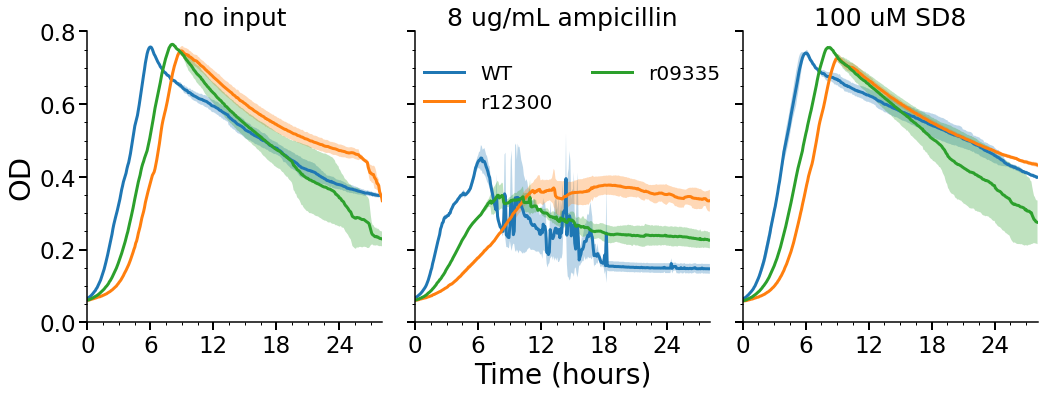

In [8]:
# take mean of each (strain, compound, concentration) and plot 
savefig = False
fig, ax = plt.subplots(1,3,figsize = (15, 6),sharex=True,sharey=True)
ax = ax.reshape(-1)
alpha = 0.3
# Set the ticks and ticklabels for all axes
plt.setp(ax, xticks=range(0,30,6), xticklabels=range(0,30,6))
for cond in adata.obs.condition.unique():
    bdata = adata[adata.obs.condition.isin([cond])].copy()
    mean = np.mean(bdata.X,axis=0)
    std = np.std(bdata.X,axis=0)
    if bdata.obs.compound[0] == 'none':
        ax[0].plot(adata.uns['t'],mean)
        ax[0].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
    elif bdata.obs.compound[0] == 'ampicillin':
        ax[1].set_title(f'{bdata.obs.concentration[0]} {bdata.obs.concentration_unit[0]} {bdata.obs.compound[0]}',fontsize=25)
        ax[1].plot(adata.uns['t'],mean)
        ax[1].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
    elif bdata.obs.compound[0] == 'SD8':
        ax[2].set_title(f'{bdata.obs.concentration[0]} {bdata.obs.concentration_unit[0]} {bdata.obs.compound[0]}',fontsize=25)
        ax[2].plot(adata.uns['t'],mean)
        ax[2].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
ax[0].set_title('no input',fontsize=25)
ax[1].set_xlabel('Time (hours)',fontsize=28)
ax[0].set_ylabel('OD',fontsize=29)
fig.legend(adata.obs.strain.unique(),frameon=False,fontsize=20,bbox_to_anchor=(0.7,0.85),ncol=2)
plt.tight_layout()
if savefig: 
    plt.savefig('/Users/aqib/desktop/bccl/antibiotic-resistance/results/OD_10.12.pdf',transparent=True,bbox_inches='tight',
               dpi=300);
plt.show()

### A. baylyi ADP1 WT, ACIAD_RS12300, and ACIAD_RS14095 -- log phase, 8 µg/mL ampicillin, 16 µg/mL ampicillin 10.16

In [9]:
dataFile = 'adp1_antibiotic_10.16.txt'
metadataFile = 'plate_layouts.xlsx'
metadatasubFile = 'adp1_antibiotic_10.16'
numRows = 8
numCols = 12
sampling_rate = 5 # minutes
adata = read_pr_data_and_metadata(dataFile,metadataFile,metadatasubFile,nRows=numRows,nCols=numCols,sampling_rate=sampling_rate)

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


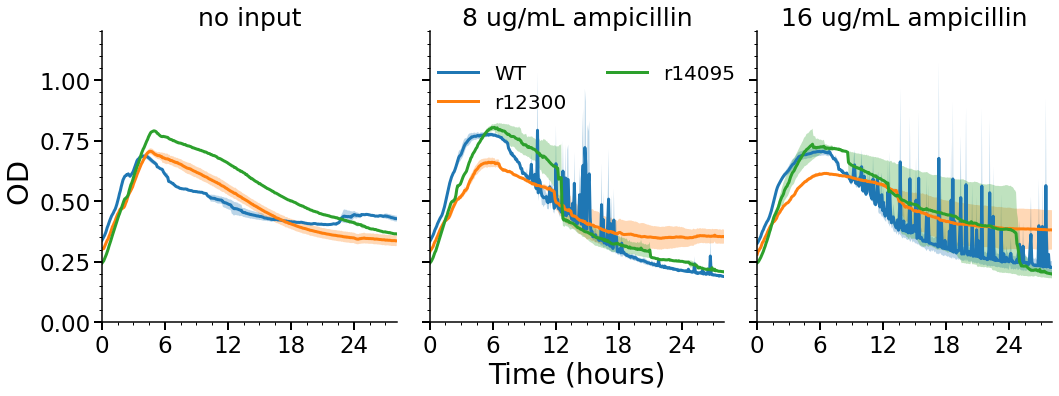

In [10]:
# take mean of each (strain, compound, concentration) and plot 
savefig = False
fig, ax = plt.subplots(1,3,figsize = (15, 6),sharex=True,sharey=True)
ax = ax.reshape(-1)
alpha = 0.3
# Set the ticks and ticklabels for all axes
plt.setp(ax, xticks=range(0,30,6), xticklabels=range(0,30,6))
for cond in adata.obs.condition.unique():
    bdata = adata[adata.obs.condition.isin([cond])].copy()
    mean = np.mean(bdata.X[0:2],axis=0)
    std = np.std(bdata.X[0:2],axis=0)
    if bdata.obs.compound[0] == 'none':
        ax[0].plot(adata.uns['t'],mean)
        ax[0].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
    elif bdata.obs.compound[0] == 'ampicillin' and bdata.obs.concentration[0] == 8:
        ax[1].set_title(f'{bdata.obs.concentration[0]} {bdata.obs.concentration_unit[0]} {bdata.obs.compound[0]}',fontsize=25)
        ax[1].plot(adata.uns['t'],mean)
        ax[1].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
    elif bdata.obs.compound[0] == 'ampicillin' and bdata.obs.concentration[0] == 16:
        ax[2].set_title(f'{bdata.obs.concentration[0]} {bdata.obs.concentration_unit[0]} {bdata.obs.compound[0]}',fontsize=25)
        ax[2].plot(adata.uns['t'],mean)
        ax[2].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
ax[0].set_title('no input',fontsize=25)
ax[1].set_xlabel('Time (hours)',fontsize=28)
ax[0].set_ylabel('OD ',fontsize=29)
fig.legend(adata.obs.strain.unique(),frameon=False,fontsize=20,bbox_to_anchor=(0.7,0.85),ncol=2)
plt.tight_layout()
if savefig: 
    plt.savefig('/Users/aqib/desktop/bccl/adp1-adaptation/results/OD_10.16.pdf',transparent=True,bbox_inches='tight',
               dpi=300);
plt.show()

### ADP1 WT and ADP1 w/ pBWB162 -- lag phase, 8 ug/mL ampicillin, vary IPTG 10.19

In [119]:
dataFile = 'adp1_antibiotic_10.19.txt'
metadataFile = 'plate_layouts.xlsx'
metadatasubFile = 'adp1_antibiotic_10.18'
numRows = 8
numCols = 12
sampling_rate = 5 # minutes
adata = read_pr_data_and_metadata(dataFile,metadataFile,metadatasubFile,nRows=numRows,nCols=numCols,sampling_rate=sampling_rate)

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


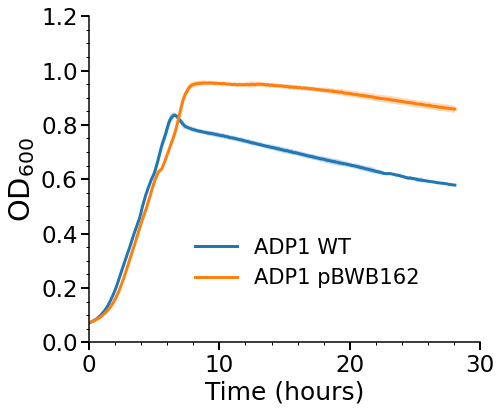

In [12]:
savefig = False

plt.figure(figsize=(7,6))
bdata = adata[adata.obs.condition.isin([0,1])].copy()
labels = ['ADP1 WT', 'ADP1 pBWB162']
for ii, strain in enumerate(bdata.obs.strain.unique()):
    cdata = bdata[bdata.obs.strain.isin([strain])].copy()
    mean = np.mean(cdata.X,axis=0)
    std = np.std(cdata.X,axis=0)
    plt.plot(adata.uns['t'],mean,label=labels[ii])
    plt.fill_between(adata.uns['t'],mean-2*std,mean+2*std,alpha=0.3)
plt.legend(frameon=False,fontsize=21,loc=(0.25,0.14))
plt.xlabel('Time (hours)',fontsize=25); plt.ylabel(r'OD$_{600}$',fontsize=29)
plt.ylim(-0.0,1.2)
if savefig: 
    plt.savefig(figDir+'fig1/ADP1_gcs.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

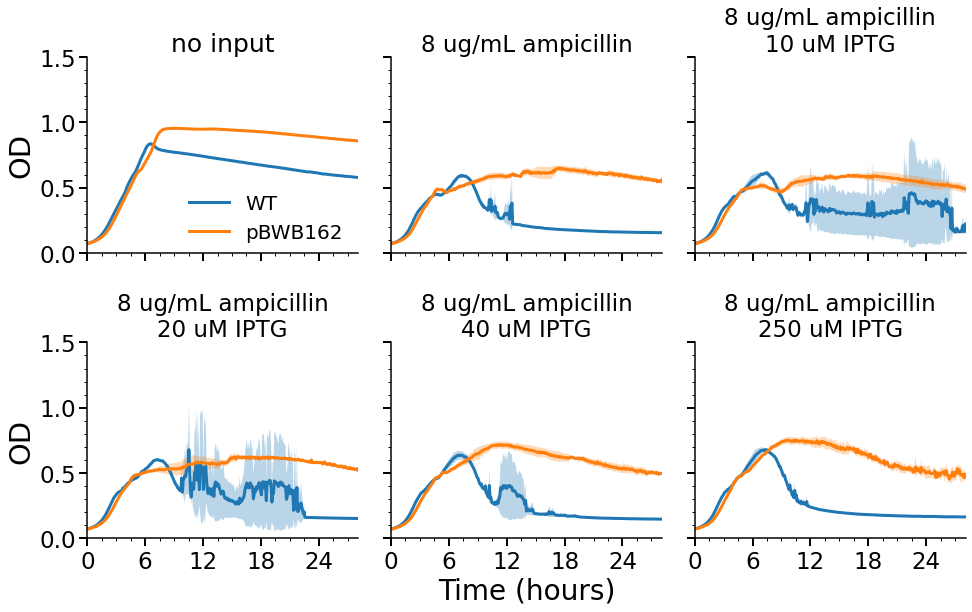

In [13]:
# take mean of each (strain, compound, concentration) and plot 
savefig = False
fig, ax = plt.subplots(2,3,figsize = (14, 9),sharex=True,sharey=True)
ax = ax.reshape(-1)
alpha = 0.3
# Set the ticks and ticklabels for all axes
plt.setp(ax, xticks=range(0,30,6), xticklabels=range(0,30,6))
for cond in adata.obs.condition.unique():
    bdata = adata[adata.obs.condition.isin([cond])].copy()
    mean = np.mean(bdata.X,axis=0)
    std = np.std(bdata.X,axis=0)
    if bdata.obs.compound_1[0] == 'none' and bdata.obs.compound_2[0] == 'none':
        ax[0].plot(adata.uns['t'],mean)
        ax[0].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
    elif bdata.obs.compound_1[0] == 'none' and bdata.obs.compound_2[0] == 'ampicillin':
        ax[1].set_title(f'{bdata.obs.concentration_2[0]} {bdata.obs.concentration_unit_2[0]} {bdata.obs.compound_2[0]}',fontsize=23)
        ax[1].plot(adata.uns['t'],mean)
        ax[1].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
    elif bdata.obs.concentration_1[0] == 10:
        ax[2].set_title(f'{bdata.obs.concentration_2[0]} {bdata.obs.concentration_unit_2[0]} {bdata.obs.compound_2[0]}' + '\n' 
                        f'{bdata.obs.concentration_1[0]} {bdata.obs.concentration_unit_1[0]} {bdata.obs.compound_1[0]}',fontsize=23)
        ax[2].plot(adata.uns['t'],mean)
        ax[2].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
    elif bdata.obs.concentration_1[0] == 20:
        ax[3].set_title(f'{bdata.obs.concentration_2[0]} {bdata.obs.concentration_unit_2[0]} {bdata.obs.compound_2[0]}' + '\n' 
                        f'{bdata.obs.concentration_1[0]} {bdata.obs.concentration_unit_1[0]} {bdata.obs.compound_1[0]}',fontsize=23)
        ax[3].plot(adata.uns['t'],mean)
        ax[3].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
    elif bdata.obs.concentration_1[0] == 40:
        ax[4].set_title(f'{bdata.obs.concentration_2[0]} {bdata.obs.concentration_unit_2[0]} {bdata.obs.compound_2[0]}' + '\n' 
                        f'{bdata.obs.concentration_1[0]} {bdata.obs.concentration_unit_1[0]} {bdata.obs.compound_1[0]}',fontsize=23)
        ax[4].plot(adata.uns['t'],mean)
        ax[4].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
    elif bdata.obs.concentration_1[0] == 250:
        ax[5].set_title(f'{bdata.obs.concentration_2[0]} {bdata.obs.concentration_unit_2[0]} {bdata.obs.compound_2[0]}' + '\n' 
                        f'{bdata.obs.concentration_1[0]} {bdata.obs.concentration_unit_1[0]} {bdata.obs.compound_1[0]}',fontsize=23)
        ax[5].plot(adata.uns['t'],mean)
        ax[5].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
ax[0].set_title('no input',fontsize=25)
ax[4].set_xlabel('Time (hours)',fontsize=28)
ax[0].set_ylabel('OD',fontsize=29); ax[3].set_ylabel('OD',fontsize=29);
fig.legend(adata.obs.strain.unique(),frameon=False,fontsize=20,bbox_to_anchor=(.375,0.7),ncol=1)
plt.tight_layout()
if savefig: 
    plt.savefig('/Users/aqib/desktop/bccl/antibiotic-resistance/results/OD_10.12.pdf',transparent=True,bbox_inches='tight',
               dpi=300);
plt.show()

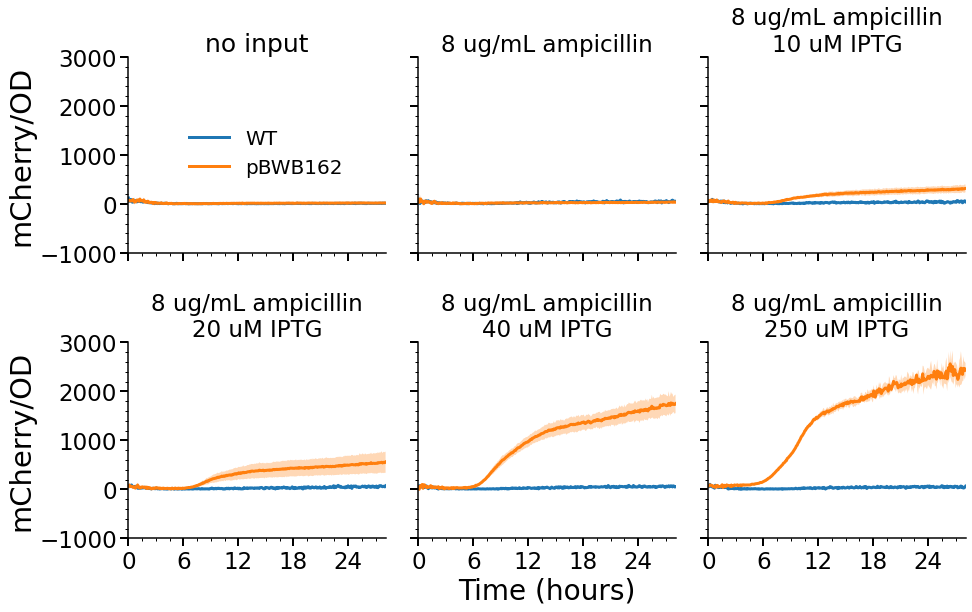

In [14]:
# take mean of each (strain, compound, concentration) and plot 
savefig = False
fig, ax = plt.subplots(2,3,figsize = (14, 9),sharex=True,sharey=True)
ax = ax.reshape(-1)
alpha = 0.3
# Set the ticks and ticklabels for all axes
plt.setp(ax, xticks=range(0,30,6), xticklabels=range(0,30,6))
for cond in adata.obs.condition.unique():
    bdata = adata[adata.obs.condition.isin([cond])].copy()
    mean = np.mean(bdata.obsm['fln'],axis=0)
    std = np.std(bdata.obsm['fln'],axis=0)
    if bdata.obs.compound_1[0] == 'none' and bdata.obs.compound_2[0] == 'none':
        ax[0].plot(adata.uns['t'],mean)
        ax[0].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
    elif bdata.obs.compound_1[0] == 'none' and bdata.obs.compound_2[0] == 'ampicillin':
        ax[1].set_title(f'{bdata.obs.concentration_2[0]} {bdata.obs.concentration_unit_2[0]} {bdata.obs.compound_2[0]}',fontsize=23)
        ax[1].plot(adata.uns['t'],mean)
        ax[1].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
    elif bdata.obs.concentration_1[0] == 10:
        ax[2].set_title(f'{bdata.obs.concentration_2[0]} {bdata.obs.concentration_unit_2[0]} {bdata.obs.compound_2[0]}' + '\n' 
                        f'{bdata.obs.concentration_1[0]} {bdata.obs.concentration_unit_1[0]} {bdata.obs.compound_1[0]}',fontsize=23)
        ax[2].plot(adata.uns['t'],mean)
        ax[2].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
    elif bdata.obs.concentration_1[0] == 20:
        ax[3].set_title(f'{bdata.obs.concentration_2[0]} {bdata.obs.concentration_unit_2[0]} {bdata.obs.compound_2[0]}' + '\n' 
                        f'{bdata.obs.concentration_1[0]} {bdata.obs.concentration_unit_1[0]} {bdata.obs.compound_1[0]}',fontsize=23)
        ax[3].plot(adata.uns['t'],mean)
        ax[3].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
    elif bdata.obs.concentration_1[0] == 40:
        ax[4].set_title(f'{bdata.obs.concentration_2[0]} {bdata.obs.concentration_unit_2[0]} {bdata.obs.compound_2[0]}' + '\n' 
                        f'{bdata.obs.concentration_1[0]} {bdata.obs.concentration_unit_1[0]} {bdata.obs.compound_1[0]}',fontsize=23)
        ax[4].plot(adata.uns['t'],mean)
        ax[4].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
    elif bdata.obs.concentration_1[0] == 250:
        ax[5].set_title(f'{bdata.obs.concentration_2[0]} {bdata.obs.concentration_unit_2[0]} {bdata.obs.compound_2[0]}' + '\n' 
                        f'{bdata.obs.concentration_1[0]} {bdata.obs.concentration_unit_1[0]} {bdata.obs.compound_1[0]}',fontsize=23)
        ax[5].plot(adata.uns['t'],mean)
        ax[5].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
ax[0].set_title('no input',fontsize=25)
ax[4].set_xlabel('Time (hours)',fontsize=28)
ax[0].set_ylabel('mCherry/OD',fontsize=29); ax[3].set_ylabel('mCherry/OD',fontsize=29);
fig.legend(adata.obs.strain.unique(),frameon=False,fontsize=20,bbox_to_anchor=(.375,0.8),ncol=1)
plt.tight_layout()
if savefig: 
    plt.savefig('/Users/aqib/desktop/bccl/antibiotic-resistance/results/OD_10.12.pdf',transparent=True,bbox_inches='tight',
               dpi=300);
plt.show()

In [15]:
# scatter plot of IPTG vs. deltaOD

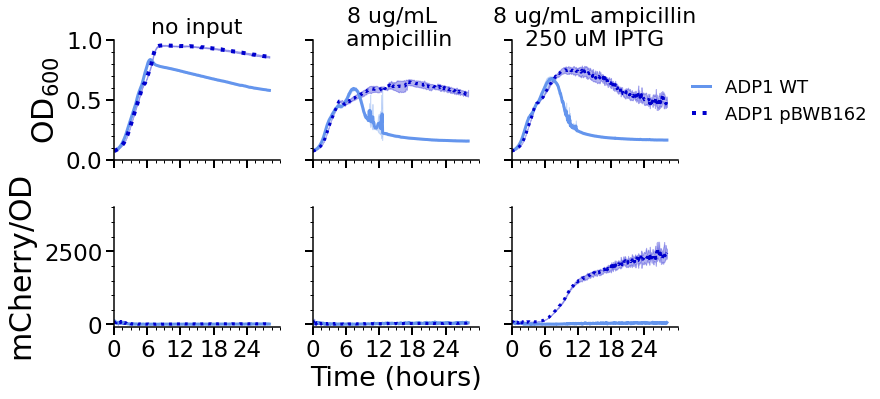

In [142]:
# amp resistance figure for paper 
savefig = False

fig, ax = plt.subplots(2,3,figsize = (10, 6),sharex=True,sharey='row')
ax = ax.reshape(-1)
alpha = 0.3
plt.setp(ax, xticks=range(0,30,6), xticklabels=range(0,30,6))
colors = ['cornflowerblue','mediumblue']
for cond in adata.obs.condition.unique():
    bdata = adata[adata.obs.condition.isin([cond])].copy()
    mean = np.mean(bdata.X,axis=0)
    std = np.std(bdata.X,axis=0)
    if bdata.obs.compound_1[0] == 'none' and bdata.obs.compound_2[0] == 'none':
        if bdata.obs.strain[0] == 'WT':
            ax[0].plot(adata.uns['t'],mean,'-',c=colors[0])
            ax[0].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[0])
        else:
            ax[0].plot(adata.uns['t'],mean,':',lw=4,c=colors[1])            
            ax[0].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[1])
    elif bdata.obs.compound_1[0] == 'none' and bdata.obs.compound_2[0] == 'ampicillin':
        ax[1].set_title(f'{bdata.obs.concentration_2[0]} {bdata.obs.concentration_unit_2[0]} \n {bdata.obs.compound_2[0]}',fontsize=22,y=0.9)
        if bdata.obs.strain[0] == 'WT':
            ax[1].plot(adata.uns['t'],mean,color=colors[0])
            ax[1].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[0])
        else: 
            ax[1].plot(adata.uns['t'],mean,':',color=colors[1])
            ax[1].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[1])        
    elif bdata.obs.concentration_1[0] == 250:
        ax[2].set_title(f'{bdata.obs.concentration_2[0]} {bdata.obs.concentration_unit_2[0]} {bdata.obs.compound_2[0]}' + '\n' 
                        f'{bdata.obs.concentration_1[0]} {bdata.obs.concentration_unit_1[0]} {bdata.obs.compound_1[0]}',fontsize=22,y=0.9)
        if bdata.obs.strain[0] == 'WT':
            ax[2].plot(adata.uns['t'],mean,c=colors[0])
            ax[2].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[0])
        else: 
            ax[2].plot(adata.uns['t'],mean,':',c=colors[1])
            ax[2].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[1])
            
for cond in adata.obs.condition.unique():
    bdata = adata[adata.obs.condition.isin([cond])].copy()
    mean = np.mean(bdata.obsm['fln'],axis=0)
    std = np.std(bdata.obsm['fln'],axis=0)
    if bdata.obs.compound_1[0] == 'none' and bdata.obs.compound_2[0] == 'none':
        if bdata.obs.strain[0] == 'WT':
            ax[3].plot(adata.uns['t'],mean,c=colors[0])
            ax[3].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[0])
        else: 
            ax[3].plot(adata.uns['t'],mean,':',c=colors[1])
            ax[3].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[1])
    elif bdata.obs.compound_1[0] == 'none' and bdata.obs.compound_2[0] == 'ampicillin':
        if bdata.obs.strain[0] == 'WT':
            ax[4].plot(adata.uns['t'],mean,c=colors[0])
            ax[4].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[0])
        else: 
            ax[4].plot(adata.uns['t'],mean,':',c=colors[1])
            ax[4].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[1])       
    elif bdata.obs.concentration_1[0] == 250:
        if bdata.obs.strain[0] == 'WT':
            ax[5].plot(adata.uns['t'],mean,c=colors[0])
            ax[5].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[0])
        else: 
            ax[5].plot(adata.uns['t'],mean,':',c=colors[1])
            ax[5].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[1])
            
ax[0].set_title('no input',fontsize=22,y=1)
ax[0].set_ylabel(r'OD$_{600}$',fontsize=30); 
ax[3].set_ylabel(r'mCherry$/$OD',fontsize=30); 
ax[4].set_xlabel('Time (hours)',fontsize=27)
# fig.text(0.46,-0.01,'Time (hours)',fontsize=25)  
fig.legend(['ADP1 WT','ADP1 pBWB162'],fontsize=18,bbox_to_anchor=(1.25,0.82),ncol=1,handlelength=1,frameon=False)
ax[4].set_ylim(-100,)
ax[0].set_xlim(0,30)
plt.tight_layout()
if savefig: 
    plt.savefig(figDir+'fig4/adp1_ampicillin.pdf',transparent=True,bbox_inches='tight',dpi=300);
plt.show()

In [143]:
# get the adp1, 250 um IPTG, 8 ug/ml amp difference in ODs at 24 hrs
t24 = int(60/sampling_rate * 24)
adp1_deltaod_mean = adata[adata.obs.condition.isin([11])].X[:,t24].mean() - adata[adata.obs.condition.isin([10])].X[:,t24].mean()
adp1_deltaod_uncertainty = adata[adata.obs.condition.isin([11])].X[:,t24].std() + adata[adata.obs.condition.isin([10])].X[:,t24].std()

In [144]:
adp1_deltaod_uncertainty, adp1_deltaod_mean

(ArrayView(0.05194045, dtype=float32), ArrayView(0.33566666, dtype=float32))

### MGZ1 WT and MGZ1 w dCasRx plasmid (from Alec), 20 uM IPTG, 5 ug/mL amp, 30C 11.9

In [145]:
dataFile = 'mgz1_antibiotic_h1_11.9.22.txt'
metadataFile = 'plate_layouts.xlsx'
metadatasubFile = 'mgz1_antibiotic_11.9'
numRows = 8
numCols = 12
sampling_rate = 5 # minutes
adata = read_pr_data_and_metadata(dataFile,metadataFile,metadatasubFile,nRows=numRows,nCols=numCols,sampling_rate=sampling_rate)

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


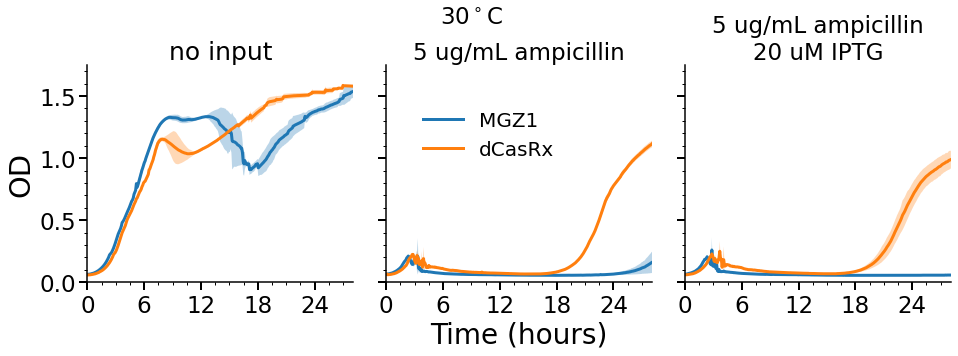

In [20]:
# take mean of each (strain, compound, concentration) and plot 
savefig = False
fig, ax = plt.subplots(1,3,figsize = (14, 6),sharex=True,sharey=True)
ax = ax.reshape(-1)
alpha = 0.3
# Set the ticks and ticklabels for all axes
plt.setp(ax, xticks=range(0,30,6), xticklabels=range(0,30,6))
for cond in adata.obs.condition.unique():
    bdata = adata[adata.obs.condition.isin([cond])].copy()
    mean = np.mean(bdata.X,axis=0)
    std = np.std(bdata.X,axis=0)
    if bdata.obs.compound_1[0] == 'none' and bdata.obs.compound_2[0] == 'none':
        ax[0].plot(adata.uns['t'],mean)
        ax[0].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
    elif bdata.obs.compound_1[0] == 'ampicillin' and bdata.obs.compound_2[0] == 'none':
        ax[1].set_title(f'{bdata.obs.concentration_1[0]} {bdata.obs.concentration_unit_1[0]} {bdata.obs.compound_1[0]}',fontsize=23)
        ax[1].plot(adata.uns['t'],mean)
        ax[1].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
    elif bdata.obs.compound_1[0] == 'ampicillin' and bdata.obs.compound_2[0] == 'IPTG':
        ax[2].set_title(f'{bdata.obs.concentration_1[0]} {bdata.obs.concentration_unit_1[0]} {bdata.obs.compound_1[0]}' + '\n' 
                        f'{bdata.obs.concentration_2[0]} {bdata.obs.concentration_unit_2[0]} {bdata.obs.compound_2[0]}',fontsize=23)
        ax[2].plot(adata.uns['t'],mean)
        ax[2].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
ax[0].set_title('no input',fontsize=25)
ax[1].set_xlabel('Time (hours)',fontsize=28)
ax[0].set_ylabel('OD',fontsize=29)
plt.suptitle(r'30$^\circ$C',fontsize=23,y=0.85)
fig.legend(adata.obs.strain.unique(),frameon=False,fontsize=20,bbox_to_anchor=(.6,0.65),ncol=1)
plt.tight_layout()
if savefig: 
    plt.savefig('/Users/aqib/desktop/bccl/antibiotic-resistance/results/OD_10.12.pdf',transparent=True,bbox_inches='tight',
               dpi=300);
plt.show()

### MGZ1 WT and MGZ1 w dCasRx plasmid (from Alec), 20 uM IPTG, 5 ug/mL amp, 37C 11.9

In [146]:
dataFile = 'mgz1_antibiotic_neo2_11.9.22.txt'
metadataFile = 'plate_layouts.xlsx'
metadatasubFile = 'mgz1_antibiotic_11.9'
numRows = 8
numCols = 12
sampling_rate = 5 # minutes
adata = read_pr_data_and_metadata(dataFile,metadataFile,metadatasubFile,nRows=numRows,nCols=numCols,sampling_rate=sampling_rate)

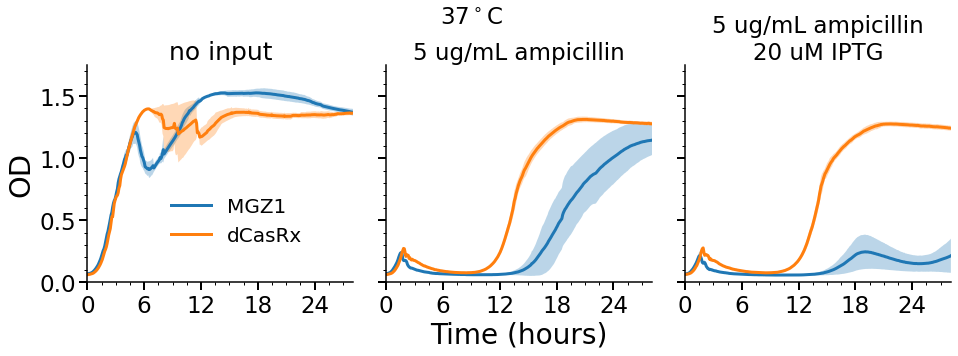

In [22]:
# take mean of each (strain, compound, concentration) and plot 
savefig = False
fig, ax = plt.subplots(1,3,figsize = (14, 6),sharex=True,sharey=True)
ax = ax.reshape(-1)
alpha = 0.3
# Set the ticks and ticklabels for all axes
plt.setp(ax, xticks=range(0,30,6), xticklabels=range(0,30,6))
for cond in adata.obs.condition.unique():
    bdata = adata[adata.obs.condition.isin([cond])].copy()
    mean = np.mean(bdata.X,axis=0)
    std = np.std(bdata.X,axis=0)
    if bdata.obs.compound_1[0] == 'none' and bdata.obs.compound_2[0] == 'none':
        ax[0].plot(adata.uns['t'],mean)
        ax[0].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
    elif bdata.obs.compound_1[0] == 'ampicillin' and bdata.obs.compound_2[0] == 'none':
        ax[1].set_title(f'{bdata.obs.concentration_1[0]} {bdata.obs.concentration_unit_1[0]} {bdata.obs.compound_1[0]}',fontsize=23)
        ax[1].plot(adata.uns['t'],mean)
        ax[1].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
    elif bdata.obs.compound_1[0] == 'ampicillin' and bdata.obs.compound_2[0] == 'IPTG':
        ax[2].set_title(f'{bdata.obs.concentration_1[0]} {bdata.obs.concentration_unit_1[0]} {bdata.obs.compound_1[0]}' + '\n' 
                        f'{bdata.obs.concentration_2[0]} {bdata.obs.concentration_unit_2[0]} {bdata.obs.compound_2[0]}',fontsize=23)
        ax[2].plot(adata.uns['t'],mean)
        ax[2].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
ax[0].set_title('no input',fontsize=25)
ax[1].set_xlabel('Time (hours)',fontsize=28)
ax[0].set_ylabel('OD',fontsize=29)
plt.suptitle(r'37$^\circ$C',fontsize=23,y=0.85)
fig.legend(adata.obs.strain.unique(),frameon=False,fontsize=20,bbox_to_anchor=(.35,0.45),ncol=1)
plt.tight_layout()
if savefig: 
    plt.savefig('/Users/aqib/desktop/bccl/antibiotic-resistance/results/OD_10.12.pdf',transparent=True,bbox_inches='tight',
               dpi=300);
plt.show()

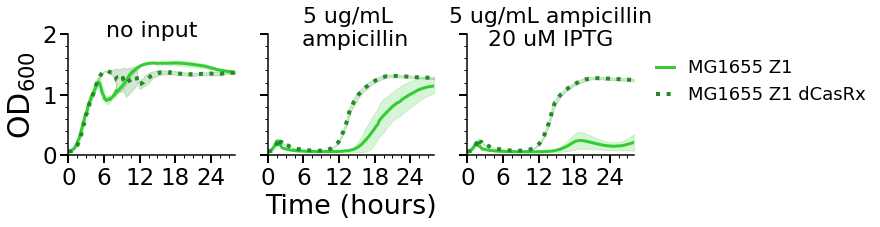

In [165]:
# amp resistance figure for paper 
savefig = False

fig, ax = plt.subplots(1,3,figsize = (9.7, 3.5),sharex=True,sharey=True)
ax = ax.reshape(-1)
alpha = 0.2
plt.setp(ax, xticks=range(0,30,6), xticklabels=range(0,30,6))
colors = ['limegreen','forestgreen']
for cond in adata.obs.condition.unique():
    bdata = adata[adata.obs.condition.isin([cond])].copy()
    mean = np.mean(bdata.X,axis=0)
    std = np.std(bdata.X,axis=0)
    if bdata.obs.compound_1[0] == 'none' and bdata.obs.compound_2[0] == 'none':
        if bdata.obs.strain[0] == 'MGZ1':
            ax[0].plot(adata.uns['t'],mean,'-',c=colors[0])
            ax[0].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[0])
        else:
            ax[0].plot(adata.uns['t'],mean,':',lw=4,c=colors[1])            
            ax[0].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[1])
    elif bdata.obs.compound_1[0] == 'ampicillin' and bdata.obs.compound_2[0] == 'none':
        ax[1].set_title(f'{bdata.obs.concentration_1[0]} {bdata.obs.concentration_unit_1[0]} \n {bdata.obs.compound_1[0]}',fontsize=22,y=0.85)
        if bdata.obs.strain[0] == 'MGZ1':
            ax[1].plot(adata.uns['t'],mean,'-',c=colors[0])
            ax[1].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[0])
        else:
            ax[1].plot(adata.uns['t'],mean,':',lw=4,c=colors[1])            
            ax[1].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[1])
    elif bdata.obs.compound_1[0] == 'ampicillin' and bdata.obs.compound_2[0] == 'IPTG':
        ax[2].set_title(f'{bdata.obs.concentration_1[0]} {bdata.obs.concentration_unit_1[0]} {bdata.obs.compound_1[0]}' + '\n' 
                        f'{bdata.obs.concentration_2[0]} {bdata.obs.concentration_unit_2[0]} {bdata.obs.compound_2[0]}',fontsize=22,y=0.85)
        if bdata.obs.strain[0] == 'MGZ1':
            ax[2].plot(adata.uns['t'],mean,'-',c=colors[0])
            ax[2].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[0])
        else:
            ax[2].plot(adata.uns['t'],mean,':',lw=4,c=colors[1])            
            ax[2].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[1])
ax[0].set_title('no input',fontsize=22,y=0.93)
ax[0].set_ylabel(r'OD$_{600}$',fontsize=30)
ax[1].set_xlabel('Time (hours)',fontsize=27)
fig.legend(['MG1655 Z1','MG1655 Z1 dCasRx'],bbox_to_anchor=(1.32,0.8),fontsize=18,ncol=1,handlelength=1,frameon=False)
plt.tight_layout()
if savefig: 
    plt.savefig(figDir+'fig4/mgz1_ampicillin.pdf',transparent=True,bbox_inches='tight',dpi=300);
plt.show()

In [166]:
# get the adp1, 250 um IPTG, 8 ug/ml amp difference in ODs at 24 hrs
t24 = int(60/sampling_rate * 24)
ecoli_deltaod_mean = adata[adata.obs.condition.isin([5])].X[:,t24].mean() - adata[adata.obs.condition.isin([4])].X[:,t24].mean()
ecoli_deltaod_uncertainty = adata[adata.obs.condition.isin([5])].X[:,t24].std() + adata[adata.obs.condition.isin([4])].X[:,t24].std()

In [167]:
ecoli_deltaod_mean, ecoli_deltaod_uncertainty

(ArrayView(1.1126666, dtype=float32), ArrayView(0.08711907, dtype=float32))

### B. subtilis 168 ampicillin test with mCherry 1x and 4x strains.

Problem is that I didn't culture the strains with antibiotic as they don't grow in erythromycin but should be resistant. So probably don't trust this experiment.

In [168]:
dataFile = '168_antibiotic_11.19.22.txt'
metadataFile = 'plate_layouts.xlsx'
metadatasubFile = '168_antibiotic_11.19' 
numRows = 8
numCols = 12
sampling_rate = 5 # minutes
adata = read_pr_data_and_metadata(dataFile,metadataFile,metadatasubFile,nRows=numRows,nCols=numCols,sampling_rate=sampling_rate)

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


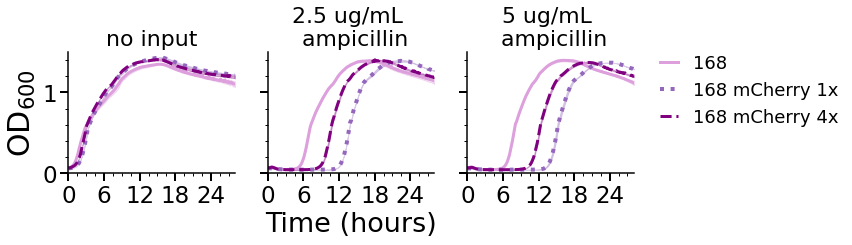

In [185]:
# take mean of each (strain, compound, concentration) and plot 
savefig = False
fig, ax = plt.subplots(1,3,figsize = (9.7, 3.9),sharex=True,sharey=True)
ax = ax.reshape(-1)
alpha = 0.3
# Set the ticks and ticklabels for all axes
plt.setp(ax, xticks=range(0,30,6), xticklabels=range(0,30,6))
colors = ['plum','tab:purple','purple']
for cond in adata.obs.condition.unique():
    bdata = adata[adata.obs.condition.isin([cond])].copy()
    mean = np.mean(bdata.X[0:2],axis=0)
    std = np.std(bdata.X[0:2],axis=0)
    if bdata.obs.compound[0] == 'none':
        if bdata.obs.strain[0] == 168:
            ax[0].plot(adata.uns['t'],mean,'-',c=colors[0])
            ax[0].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[0])
        elif bdata.obs.strain[0] == '1x':
            ax[0].plot(adata.uns['t'],mean,':',lw=4,c=colors[1])            
            ax[0].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[1])
        else: 
            ax[0].plot(adata.uns['t'],mean,'--',lw=3,c=colors[2])            
            ax[0].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[2])            
    elif bdata.obs.compound[0] == 'ampicillin' and bdata.obs.concentration[0] == 2.5:
        ax[1].set_title(f'{bdata.obs.concentration[0]} {bdata.obs.concentration_unit[0]} \n {bdata.obs.compound[0]}',fontsize=22,)
        if bdata.obs.strain[0] == 168:
            ax[1].plot(adata.uns['t'],mean,'-',c=colors[0])
            ax[1].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[0])
        elif bdata.obs.strain[0] == '1x':
            ax[1].plot(adata.uns['t'],mean,':',lw=4,c=colors[1])            
            ax[1].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[1])
        else: 
            ax[1].plot(adata.uns['t'],mean,'--',lw=3,c=colors[2])            
            ax[1].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[2])            
    elif bdata.obs.compound[0] == 'ampicillin' and bdata.obs.concentration[0] == 5:
        ax[2].set_title(f'{bdata.obs.concentration[0]} {bdata.obs.concentration_unit[0]} \n {bdata.obs.compound[0]}',fontsize=22,)
        if bdata.obs.strain[0] == 168:
            ax[2].plot(adata.uns['t'],mean,'-',c=colors[0])
            ax[2].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[0])
        elif bdata.obs.strain[0] == '1x':
            ax[2].plot(adata.uns['t'],mean,':',lw=4,c=colors[1])            
            ax[2].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[1])
        else: 
            ax[2].plot(adata.uns['t'],mean,'--',lw=3,c=colors[2])            
            ax[2].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[2])            
ax[0].set_title('no input',fontsize=22)
ax[1].set_xlabel('Time (hours)',fontsize=27)
ax[0].set_ylabel(r'OD$_{600}$',fontsize=30); 
# fig.legend(adata.obs.strain.unique(),frameon=False,fontsize=20,bbox_to_anchor=(0.7,0.85),ncol=2)
fig.legend(['168','168 mCherry 1x', '168 mCherry 4x'],bbox_to_anchor=(1.28,0.8),fontsize=18,ncol=1,handlelength=1,frameon=False)
plt.tight_layout()
if savefig: 
    plt.savefig(figDir+'fig4/168_ampicillin_OD.pdf',transparent=True,bbox_inches='tight',dpi=300);
plt.show()

In [188]:
# get the adp1, 250 um IPTG, 8 ug/ml amp difference in ODs at 24 hrs
t24 = int(60/sampling_rate * 24)
bsubt_deltaod_mean = adata[adata.obs.condition.isin([8])].X[:,t24].mean() - adata[adata.obs.condition.isin([6])].X[:,t24].mean()
bsubt_deltaod_uncertainty = adata[adata.obs.condition.isin([8])].X[:,t24].std() + adata[adata.obs.condition.isin([6])].X[:,t24].std()

In [189]:
bsubt_deltaod_mean, bsubt_deltaod_uncertainty

(ArrayView(0.03133345, dtype=float32), ArrayView(0.03862113, dtype=float32))

### Bar plot showing $\Delta$OD at 24 hours for the tested strains 

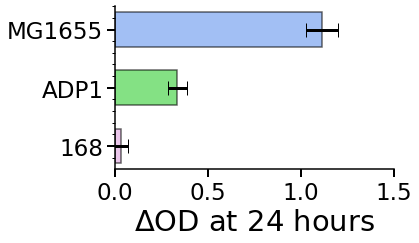

In [214]:
savefig = False

plt.rcParams['xtick.minor.visible'] = False;

plt.figure(figsize=(5,3))
plt.barh([0,0.5,1],[bsubt_deltaod_mean, adp1_deltaod_mean, ecoli_deltaod_mean],xerr=[bsubt_deltaod_uncertainty ,adp1_deltaod_uncertainty, ecoli_deltaod_uncertainty]
        ,capsize=7,height=0.3,color=['plum','limegreen','cornflowerblue'],alpha=0.6,edgecolor='k',linewidth=1.5)
plt.yticks([0,0.5,1],['168','ADP1', 'MG1655'])
plt.xlabel(r'$\Delta$OD at 24 hours',fontsize=29)
plt.ylim(-0.2,1.2)
plt.xlim(0,)
if savefig:
    plt.savefig(figDir+'fig4/bar_deltaod.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

plt.rcParams['xtick.minor.visible'] = True; 